# Imports

In [2]:
import gc
import glob
import os
import pathlib
from collections import defaultdict
from functools import partial
from itertools import product

import modin.pandas as pd
import numpy as np

# import dask.dataframe as pd
import plotly.express as px
import ray
from IPython.display import Image
from numba import njit
from tqdm.auto import tqdm, trange

# from tqdm import write
from tqdm.contrib.concurrent import process_map

# import pandas as pd


ray.shutdown()
ray.init()

2022-07-24 03:39:08,446	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.10.5', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '192.168.31.219', 'raylet_ip_address': '192.168.31.219', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-07-24_03-39-06_309941_134337/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-07-24_03-39-06_309941_134337/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-07-24_03-39-06_309941_134337', 'metrics_export_port': 58816, 'gcs_address': '192.168.31.219:64519', 'address': '192.168.31.219:64519', 'node_id': 'e5a18ef2d1179728a98d22c7f2c5962e0b3e418b5be0fd962de5af29'})

# Split the data

Put the data in folder `data`. Extract every file in the folder with the same name. If needed, adapt the path.

In [5]:
tsv_paths = sorted(
    glob.glob("data/NSDUH_Versions/*/*/*.tsv")
    + glob.glob("data/NSDUH_Versions/*/*/*/*.tsv")
)
tsv_paths = [
    path
    for path in tsv_paths
    if "Tab" not in path and any(f"{year}.tsv" in path for year in range(2002, 2015))
]

tsv_paths

['data/NSDUH_Versions/NSDUH_Versions/NSDUH-2002-2014-DS0001-bndl-data-tsv/NSDUH-2002-2014-DS0001-data/2002.tsv',
 'data/NSDUH_Versions/NSDUH_Versions/NSDUH-2002-2014-DS0001-bndl-data-tsv/NSDUH-2002-2014-DS0001-data/2003.tsv',
 'data/NSDUH_Versions/NSDUH_Versions/NSDUH-2002-2014-DS0001-bndl-data-tsv/NSDUH-2002-2014-DS0001-data/2004.tsv',
 'data/NSDUH_Versions/NSDUH_Versions/NSDUH-2002-2014-DS0001-bndl-data-tsv/NSDUH-2002-2014-DS0001-data/2005.tsv',
 'data/NSDUH_Versions/NSDUH_Versions/NSDUH-2002-2014-DS0001-bndl-data-tsv/NSDUH-2002-2014-DS0001-data/2006.tsv',
 'data/NSDUH_Versions/NSDUH_Versions/NSDUH-2002-2014-DS0001-bndl-data-tsv/NSDUH-2002-2014-DS0001-data/2007.tsv',
 'data/NSDUH_Versions/NSDUH_Versions/NSDUH-2002-2014-DS0001-bndl-data-tsv/NSDUH-2002-2014-DS0001-data/2008.tsv',
 'data/NSDUH_Versions/NSDUH_Versions/NSDUH-2002-2014-DS0001-bndl-data-tsv/NSDUH-2002-2014-DS0001-data/2009.tsv',
 'data/NSDUH_Versions/NSDUH_Versions/NSDUH-2002-2014-DS0001-bndl-data-tsv/NSDUH-2002-2014-DS0001

In [1]:
version_mapping = {
    "2002-2014": "1",
    "2002-2015": "2",
    "2002-2017": "3",
    "2002-2018": "4",
    "2002-2019": "5",
}

In [ ]:
# data_path = "data/NSDUH_versions2"
# pathlib.Path(data_path).mkdir(exist_ok=True)


# for v, tsv_path in enumerate(tqdm(tsv_paths)):
#     v_path = os.path.join(data_path, f"V{v}")
#     pathlib.Path(v_path).mkdir(exist_ok=True)

#     tqdm.write("Loading data")
#     with open(tsv_paths[1].replace(".tsv", ".txt"), "r") as f:
#         dtype = eval(f.read())
#         dtype = {k: v if v != int else float for k, v in dtype.items()}
#     # dtype = {col: float if col != "FILEDATE" else "str" for col in header}
#     df = pd.read_csv(tsv_path, sep="\t", dtype=dtype)
#     tqdm.write("Data loaded")

#     for year, df_ in tqdm(df.groupby("YEAR")):
#         path = os.path.join(v_path, f"NSDUN_{year}.pickle")
#         df_.to_pickle(path, index=False)

#     del df
#     gc.collect()

  0%|          | 0/5 [00:00<?, ?it/s]

Loading data


/home/astadnik/.virtualenvs/masters/lib/python3.10/site-packages/modin/pandas/dataframe.py:155: UserWarning:

Distributing <class 'list'> object. This may take some time.



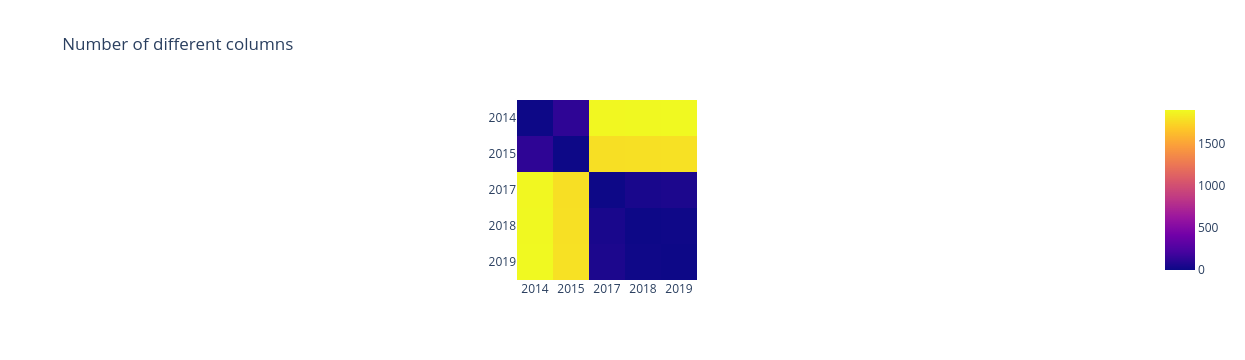

In [8]:
headers = []
for tsv_path in tsv_paths:
    with open(tsv_path, "r") as f:
        headers.append(next(f).split("\t"))

headers = [set(h) for h in headers]

diffs = [[h1 ^ h2 for h2 in headers] for h1 in headers]
n_diffs = [[len(v) for v in row] for row in diffs]
names = [str(year) for year in range(2014, 2020) if year != 2016]
px.imshow(
    pd.DataFrame(n_diffs, index=names, columns=names),
    title="Number of different columns",
)

# Try all combinations

In [13]:
tsv_paths[0]

'data/NSDUH_Versions/NSDUH_Versions/NSDUH-2002-2014-DS0001-bndl-data-tsv/NSDUH-2002-2014-DS0001-data/2002.tsv'

In [ ]:
numbers = {year: {} for year in range(2002, 2015)}

for tsv_path in tqdm(tsv_paths):
    tqdm.write("Loading data")
    parent_dir = os.path.dirname(tsv_path)
    with open(os.path.join(parent_dir, "schema.txt"), "r") as f:
        dtype = eval(f.read())
        dtype = {k: v if v != int else float for k, v in dtype.items()}
    df = pd.read_csv(tsv_path, sep="\t", dtype=dtype)
    tqdm.write("Data loaded")

    year = int(tsv_path.split("/")[-1].removesuffix(".tsv"))
    version = None
    for pat, v in version_mapping.items():
        if pat in tsv_path:
            version = v
            break
    assert version is not None
    
    if df['AGE2'].dtype == str:
        df['AGE2'] = df['AGE2'].str.split().str[0].astype(int)
    numbers[year][version] = df[df["AGE2"] <= 10].shape[0]

  0%|          | 0/65 [00:00<?, ?it/s]

Loading data


In [ ]:
good = pd.read_csv(tsv_paths[0][1], sep="\t", skipinitialspace=True, usecols=cols)
bad = pd.read_csv(tsv_paths[0][2], sep="\t", skipinitialspace=True, usecols=cols)

In [ ]:
bad_full.columns[2084]

In [ ]:
bad_full = pd.read_csv(tsv_paths[0][2], sep="\t", skipinitialspace=True)

In [ ]:
import numpy as np

In [ ]:
bad2 = pd.read_csv(tsv_paths[0][2], sep="\t", dtype={"GQTYPE": np.int64})

In [ ]:
bad2

In [ ]:
bad_full.iloc[:, 2084].dtype

In [ ]:
good

In [ ]:
dfs = [
    process_map(
        partial(pd.read_csv, sep="\t", skipinitialspace=True, usecols=cols), paths
    )
    for paths in tqdm(tsv_paths)
]

In [ ]:
dfs[0][3].iloc[:, 1864]

In [ ]:
for dfs_ in tqdm(dfs):
    for df in dfs_:
        df["AGE2"] = pd.to_numeric(df["AGE2"].str.split().str[0])

In [ ]:
from itertools import product

In [ ]:
rez = {}

N = sum(1 for _ in product(*tsv_paths))
for paths, dfs_ in tqdm(zip(product(*tsv_paths), product(*dfs)), total=N):
    n1, n2 = 0, 0
    for df in dfs_:
        n1 += len(df[df["AGE2"].str.split().str[0] <= 10])
        n2 += len(df[df["AGE2"].str.split().str[0] < 10])

    rez[paths] = (n1, n2)

In [ ]:
# dfs = process_map(
#     partial(pd.read_csv, sep="\t", skipinitialspace=True, usecols=cols), tsv_paths
# )
data_path = "data/NSDUN_versions"
if not os.path.exists(data_path):
    os.mkdir(data_path)

for v, tsv_path in enumerate(tqdm(tsv_paths)):
    v_path = os.path.join(data_path, f"V{v}")
    if not os.path.exists(v_path):
        os.mkdir(v_path)
    df = pd.read_csv(tsv_paths[0], sep="\t", skipinitialspace=True, engine="python")
    for year in trange(2002, 2015):
        df[df["YEAR"] == year].to_pickle(os.path.join(v_path, f"NSDUN_{year}.pkl"))

    del df

/home/astadnik/.virtualenvs/masters/lib/python3.10/site-packages/dask/dataframe/io/csv.py:182: DtypeWarning: Columns (1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682,1683,1684,1685,1686,1687,1688,1689,1690,1691,1692,1693,1694,1695,1696,1697,1698,1699,1700,1701,1702,1703,1704,1705,1706,1707,1708,1709,1710,1711,1712,1713,1714,1715,1716,1717,1718,1719,1720,1721,1722,1723,1724,1725,1726,1727,1728,1729,1730,1731,1732,1733,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1745,1746,1747,1748,1749,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,18